In [1]:
import numpy as np
from math import pi
from random import random, gauss, seed
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD, RMSprop, Adam
from keras.callbacks import EarlyStopping
import copy
import time
import pandas as pd
import json
import datetime

2024-12-11 18:15:16.005480: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:

# Constants
RESULT_LOG = 'hyperparameter_spiral_log.txt'
SUMMARY_LOG = 'spiral_results_summary.csv'

def convert_numpy(obj):
    """Convert unsupported types for JSON serialization."""
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, type):  # Handle type objects (e.g., SGD, RMSprop)
        return obj.__name__  # Convert type to its name as a string
    else:
        raise TypeError(f"Type {type(obj)} not serializable")
    
# Section 1: Data Generation
def generate_class(mean, var, points, b=0.0, a=0.1, mult=1.0):
    """Generate spiral data for a single class."""
    x, y = [], []
    for _ in range(points):
        t = random() * 10
        xi_x = gauss(mean, var)
        xi_y = gauss(mean, var)
        x.append(mult * a * t * np.cos(t + b) + xi_x)
        y.append(mult * a * t * np.sin(t + b) + xi_y)
    return np.column_stack((x, y))

def generate_data(points, var, seed_val):
    """Generate data for all four classes."""
    seed(seed_val)
    class_1 = generate_class(0.0, var, points, b=0.0)
    class_2 = generate_class(0.0, var, points, b=pi / 2)
    class_3 = generate_class(0.0, var, points, b=pi)
    class_4 = generate_class(0.0, var, points, b=3 * pi / 2)
    x_data = np.concatenate((class_1, class_2, class_3, class_4), axis=0)
    y_data = np.repeat(range(4), points)
    return x_data, y_data

In [3]:
# Generate training and testing datasets
x_train, y_train = generate_data(points=1000, var=0.03, seed_val=42)
x_test, y_test = generate_data(points=300, var=0.03, seed_val=24)

In [4]:
# Section 2: Data Preprocessing
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [5]:
# Section 3: Evaluation Function
def eval_hyperparameters(param):
    """Evaluate a model with given hyperparameters."""
    model = Sequential()
    model.add(Dense(param['layers']['neurons']['hidden_layer_1'], activation=param['activation_function'], input_shape=(2,)))
    for layer in range(2, param['layers']['num_hidden_layers']):
        model.add(Dense(param['layers']['neurons'][f'hidden_layer_{layer}'], activation=param['activation_function']))
    model.add(Dense(4, activation='softmax'))  # Output layer
    optimizer = param['optimizer'](learning_rate=param['learning_rate'])
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
    history = model.fit(
        x_train, y_train, epochs=250, batch_size=param['batch_size'],
        validation_split=0.2, callbacks=[early_stopping], verbose=0
    )
    loss, acc = model.evaluate(x_test, y_test, verbose=0)
    return loss, acc

In [6]:
# Section 4: Enhanced ES(1+1) with Step Size Logging
def run_es_one_plus_one(hyperparameters, max_generations=1000, max_runtime=3600, stagnation_limit=50):
    """Run ES(1+1) with the 1/5th rule, including step size tracking."""
    # Initial step sizes for each hyperparameter
    step_sizes = {
        'neurons': 0.82,  # Initial step size for neuron adjustments
        'learning_rate': 0.82,  # Initial step size for learning rate adjustments
        'layers_mutation_rate': 0.5,
        'mutation_rate': 0.2
    }
    success_count = 0
    results = []
    start_time = time.time()

    # Initialize parent configuration
    num_hidden_layers = np.random.randint(2, 10)  # Define the number of hidden layers first
    parent = {'layers': {'num_hidden_layers': num_hidden_layers, 'neurons': {f'hidden_layer_{i+1}': np.random.randint(8, 512) for i in range(num_hidden_layers)}},
        'learning_rate': np.random.uniform(0.01, 0.1),
        'batch_size': np.random.randint(1, 64),
        'activation_function': np.random.choice(['relu', 'elu', 'sigmoid', 'tanh']),
        'optimizer': np.random.choice([SGD, RMSprop, Adam])
    }

    # Evaluate parent
    parent_loss, parent_acc = eval_hyperparameters(parent)
    parent['loss'], parent['accuracy'] = parent_loss, parent_acc
    best_loss = parent_loss
    stagnation_counter = 0

    for generation in range(1, max_generations + 1):
        # Stop if runtime exceeds limit
        if time.time() - start_time > max_runtime:
            print("Reached max runtime. Stopping early.")
            break

        # Create offspring
        offspring = copy.deepcopy(parent)

        # Adjust the number of neurons for each hidden layer
        for key in offspring['layers']['neurons']:
            # Add Gaussian noise to the number of neurons
            offspring['layers']['neurons'][key] += int(np.round(np.random.normal(0, step_sizes['neurons'])))
            # Clip the number of neurons to stay within valid bounds
            offspring['layers']['neurons'][key] = np.clip(offspring['layers']['neurons'][key], 8, 512)

        # Adjust the learning rate
        offspring['learning_rate'] += np.random.normal(0, step_sizes['learning_rate'])
        offspring['learning_rate'] = np.clip(offspring['learning_rate'], 0.01, 0.1)

        # Adjust the number of hidden layers dynamically
        if np.random.random() < step_sizes['layers_mutation_rate']:  # 50% chance to add/remove a layer
            if np.random.random() < step_sizes['layers_mutation_rate'] and offspring['layers']['num_hidden_layers'] > 1:
                # Remove a layer if the number of hidden layers is greater than 1
                del offspring['layers']['neurons'][f'hidden_layer_{offspring["layers"]["num_hidden_layers"]}']
                offspring['layers']['num_hidden_layers'] -= 1
            elif offspring['layers']['num_hidden_layers'] < 10:  # Limit max layers to 10
                # Add a new layer
                offspring['layers']['num_hidden_layers'] += 1
                offspring['layers']['neurons'][f'hidden_layer_{offspring["layers"]["num_hidden_layers"]}'] = np.random.randint(8, 512)

        # Adjust batch size
        offspring['batch_size'] += int(np.round(np.random.normal(0, step_sizes['neurons'])))
        offspring['batch_size'] = np.clip(offspring['batch_size'], 16, 128)

        # Adjust activation function
        if np.random.random() < step_sizes['mutation_rate']:  # 20% chance to change activation function
            offspring['activation_function'] = np.random.choice(['relu', 'elu', 'sigmoid', 'tanh'])

        # Adjust optimizer
        if np.random.random() < step_sizes['mutation_rate']:  # 20% chance to change optimizer
            offspring['optimizer'] = np.random.choice([SGD, RMSprop, Adam])


        # Evaluate offspring
        offspring_loss, offspring_acc = eval_hyperparameters(offspring)
        offspring['loss'], offspring['accuracy'] = offspring_loss, offspring_acc

        # Check for improvement
        if offspring_loss < parent_loss:
            parent = copy.deepcopy(offspring)
            parent_loss = offspring_loss
            parent_acc = offspring_acc
            success_count += 1
            stagnation_counter = 0
        else:
            stagnation_counter += 1

        # Apply 1/5th rule every 10 generations
        if generation % 10 == 0:
            success_rate = success_count / 10.0
            if success_rate > 0.2:
                step_sizes['neurons'] /= 0.9  # Increase neuron step size
                step_sizes['learning_rate'] /= 0.9  # Increase learning rate step size
                step_sizes['layers_mutation_rate'] /=0.9
                step_sizes['mutation_rate'] /=0.9
            else:
                step_sizes['neurons'] *= 0.9  # Decrease neuron step size
                step_sizes['learning_rate'] *= 0.9  # Decrease learning rate step size
                step_sizes['layers_mutation_rate'] *= 0.9
                step_sizes['mutation_rate'] *= 0.9
            success_count = 0  # Reset success count

        # Log step size changes

        # Stop if stagnation limit is reached
        if stagnation_counter >= stagnation_limit:
            print("Stagnation reached. Stopping early.")
            break

        results.append({
            "generation": generation,
            "loss": parent_loss,
            "accuracy": parent_acc,
            "step_sizes": step_sizes.copy(),
        })

    return parent, generation, parent_acc, parent_loss, results

In [7]:
# Update logging in run_multiple_trials_improved to include step sizes
def run_multiple_trials_improved(hyperparameters, max_trials=5, max_generations=1000, max_runtime=3600):
    """Run multiple trials of ES(1+1) with enhanced logging and step size tracking."""
    all_results = []

    # Open summary log file for writing
    with open(SUMMARY_LOG, 'w') as summary_file:
        summary_file.write("Trial,Generation,Loss,Accuracy,Step Sizes,Hyperparameters,Timestamp\n")

    for trial in range(max_trials):
        print(f"Starting Trial {trial + 1} of {max_trials}")

        # Run a single ES(1+1) optimization
        best_config, gen, acc, loss, step_size_changes = run_es_one_plus_one(hyperparameters, max_generations, max_runtime)

        # Log detailed results to file
        timestamp = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        with open(RESULT_LOG, 'a') as log_file:
            log_file.write(json.dumps({
                "trial": trial + 1,
                "generation": gen,
                "loss": loss,
                "accuracy": acc,
                "step_size_changes": step_size_changes,
                "hyperparameters": best_config,
                "timestamp": timestamp
            }, default=convert_numpy) + "\n")

        # Log summary results to summary file
        with open(SUMMARY_LOG, 'a') as summary_file:
            summary_file.write(f"{trial + 1},{gen},{loss:.4f},{acc:.2f},{step_size_changes},{best_config},{timestamp}\n")

        # Save result for analysis
        all_results.append({
            "trial": trial + 1,
            "generation": gen,
            "loss": loss,
            "accuracy": acc,
            "step_size_changes": step_size_changes,
            "hyperparameters": best_config,
            "timestamp": timestamp
        })

    return all_results

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

# Updated function to plot decision boundary with dataset range (-1 to 1)
def plot_decision_boundary(model, X, y, title="Decision Boundary"):
    """Plots the decision boundary of a trained model with fixed range."""
    # Define the range of the grid
    x_min, x_max = -1, 1
    y_min, y_max = -1, 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))
    
    # Predict on the grid
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = np.argmax(Z, axis=1)
    Z = Z.reshape(xx.shape)
    
    # Create the plot
    plt.contourf(xx, yy, Z, alpha=0.8, cmap='Pastel1')
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', marker='o', cmap='viridis')
    plt.title(title)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.grid(True)
    plt.show()

# Function to plot loss over generations
import seaborn as sns

def plot_loss_over_generations(results):
    """
    Plots the loss over generations from ES(1+1) with smooth curves.
    """
    generations = [res['generation'] for res in results]
    losses = [res['loss'] for res in results]

    # Smooth the line for better visualization
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))
    sns.lineplot(x=generations, y=losses, marker='o', label="Loss", linewidth=2)

    # Customize the plot
    plt.title("Loss Over Generations", fontsize=14, fontweight="bold")
    plt.xlabel("Generation", fontsize=12)
    plt.ylabel("Loss", fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.legend(fontsize=10)
    plt.show()

# Function to plot a confusion matrix
def plot_confusion_matrix(model, X_test, y_test, class_names):
    """Plots a confusion matrix for the test set."""
    # Predict the labels for the test set
    y_pred = model.predict(X_test)
    y_pred = np.argmax(y_pred, axis=1)
    
    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=range(len(class_names)))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    
    # Plot the confusion matrix
    disp.plot(cmap='Blues', values_format='d')
    plt.title("Confusion Matrix")
    plt.show()


In [9]:
# After running trials, visualize the results
results = run_multiple_trials_improved(hyperparameters)

# Get the best model's parameters
best_result = min(results, key=lambda x: x["loss"])

Starting Trial 1 of 5


2024-12-11 18:16:20.507637: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-12-11 18:16:20.542919: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-12-11 18:16:20.547410: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-12-11 18:16:20.548941: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operation

Stagnation reached. Stopping early.
Starting Trial 2 of 5
Stagnation reached. Stopping early.
Starting Trial 3 of 5
Stagnation reached. Stopping early.
Starting Trial 4 of 5
Stagnation reached. Stopping early.
Starting Trial 5 of 5
Stagnation reached. Stopping early.


In [12]:
# Rebuild the best model to plot its decision boundary
best_model_params = best_result["hyperparameters"]
best_model = Sequential()
best_model.add(Dense(best_model_params['layers']['neurons']['hidden_layer_1'], 
                     activation=best_model_params['activation_function'], 
                     input_shape=(2,)))
for layer in range(2, best_model_params['layers']['num_hidden_layers'] + 1):
    best_model.add(Dense(best_model_params['layers']['neurons'][f'hidden_layer_{layer}'], 
                         activation=best_model_params['activation_function']))
best_model.add(Dense(4, activation='softmax'))
optimizer = best_model_params['optimizer'](learning_rate=best_model_params['learning_rate'])
best_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the best model on the full training data
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
best_model.fit(x_train, y_train, epochs=250, batch_size=best_model_params['batch_size'], 
               validation_split=0.2, callbacks=[early_stopping], verbose=0)

1250/1250 [==============================] - 1s 814us/step


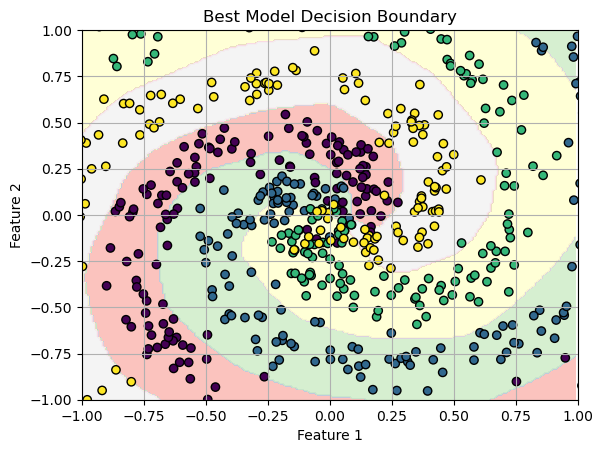

In [13]:
# Plot the decision boundary of the best model
plot_decision_boundary(best_model, x_test, y_test, title="Best Model Decision Boundary")

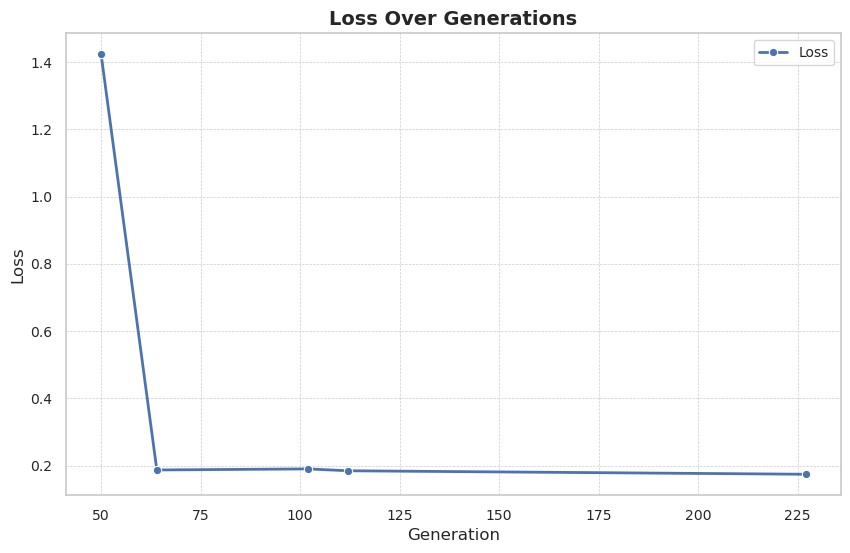

In [14]:
# Plot the loss over generations
plot_loss_over_generations(results)

38/38 [==============================] - 0s 973us/step


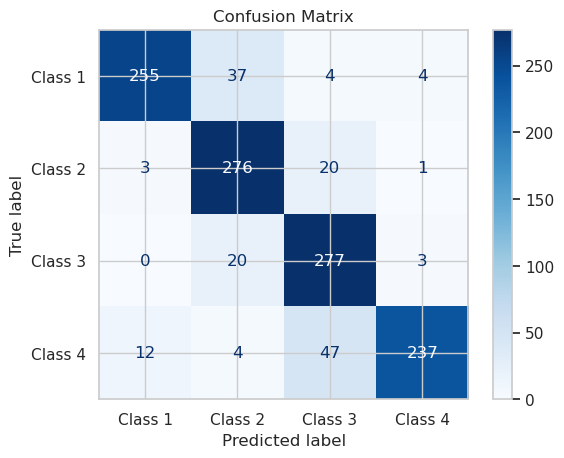

In [18]:
class_names = ["Class 1", "Class 2", "Class 3", "Class 4"]
plot_confusion_matrix(best_model, x_test, y_test, class_names)

In [16]:
# Save the best hyperparameters to a text file
try:
    with open("best_hyperparameters.txt", 'w') as best_file:
        for key, value in best_result.items():
            # Handle type objects by converting them to their names
            if isinstance(value, type):  # Check if the value is a type object
                value = value.__name__
            best_file.write(f"{key}: {value}\n")



    print("Best hyperparameters saved to 'best_hyperparameters.txt'.")
except Exception as e:
    print(f"Error saving best hyperparameters: {e}")

Best hyperparameters saved to 'best_hyperparameters.txt'.
